In [233]:
import nltk
import re
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim

#nltk.download( 'stopwords' )
#nltk.download( 'reuters' )
# nltk.download('averaged_perceptron_tagger')

from nltk.corpus import reuters
# nltk.download('punkt') -- Punkt Sentence Tokenizer
# This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. 

stop_word = nltk.corpus.stopwords.words('english') + ['said', 'nine']

In [249]:
def porter_stem( txt ):
    """Porter stem terms in text block
    Args: txt (list of string): Text block as list of individual terms
    Returns:(list of string): Text block with terms Porter stemmed
    """
    porter = nltk.stem.porter.PorterStemmer()

    for i in range( 0, len( txt ) ):
        txt[ i ] = porter.stem( txt[ i ] )

    return txt

def remove_stop_word(txt,stop_word):
    """Remove all stop words from text blo
    Args: txt (list of string): Text block as list of individual terms
    Returns: (list of string): Text block with stop words removed
    """
    term_list = [ ]
   
    for term in txt:
        term_list += ( [ ] if term.lower().strip() in stop_word or len(term.strip()) < 4 else [ term.lower().strip() ] )

    return term_list

def clean_text(currentText, pos_pick = False):
    if(pos_pick):
        currentText = [token for token, pos in nltk.pos_tag(nltk.word_tokenize(currentText)) 
                       if pos in ('JJ', 'JJR', 'JJS','NNP', 'NN', 'NNS', 'RB', 'RBS', 'VB', 'VBD', 'VBN', 'VBP', 'VBZ')]
        # print(currentText)
        currentText = " ".join(currentText)
    
    punc = string.punctuation.replace( '-', '' ) # had done this for IAA, not sure why
    currentText = re.sub( '[' + punc + ']+', '', currentText )
    currentText = re.sub( '-', ' ', currentText )
    
    currentText = re.sub('[0-9]+[a-z]', '', currentText)
    currentText = re.sub('\d', '', currentText)
        
    currentText = currentText.split()
        
    currentText = remove_stop_word( currentText , stop_word )
       
    # currentText = porter_stem( currentText ) 
    # print("func: " + str(currentText))
    
    currentText = " ".join(currentText)
    return currentText

def elbow( X, max_clust=20 ):
    distort = [ ]
    inertia = [ ]

    map_distort = { }
    map_inertia = { }

    elbow_distort = 1
    elbow_inertia = 1

    K = range( 1, max_clust )
    for k in K:
        # print(k)
        kmean_model = KMeans( n_clusters=k )
        kmean_model.fit( X )

        distort.append( sum( np.min( cdist( X, kmean_model.cluster_centers_, 'euclidean' ), axis=1 ) ) / X.shape[ 0 ] )
        inertia.append( kmean_model.inertia_ )

        map_distort[ k ] = sum( np.min( cdist( X, kmean_model.cluster_centers_, 'euclidean' ), axis=1 ) ) / X.shape[ 0 ]
        map_inertia[ k ] = kmean_model.inertia_

    prev_k = ''
    prev_v = 0
    prev_pct = 0
    for i,(k,v) in enumerate( map_distort.items() ):
        if prev_k == '':
            # print( f'{k}: {v:.4f}' )
            prev_k = str( k )
            prev_v = v
            continue

        # print( f'{k}: {v:.4f} ', end='' )

        diff_v = prev_v - v
        diff_v_pct = diff_v / prev_v * 100.0
        # print( f'{diff_v:.4f}, {diff_v_pct:.2f}%' )

        if i > 2 and prev_pct - diff_v_pct < 0.5:
            elbow_distort = i + 1
            break

        prev_k = str( k )
        prev_v = v
        prev_pct = diff_v_pct
        
    # print()

    prev_k = ''
    prev_v = 0
    prev_pct = 0
    for i,(k,v) in enumerate( map_inertia.items() ):
        if prev_k == '':
            # print( f'{k}: {v:.4f}' )
            prev_k = str( k )
            prev_v = v
            continue

        # print( f'{k}: {v:.4f} ', end='' )

        diff_v = prev_v - v
        diff_v_pct = diff_v / prev_v * 100.0
        # print( f'{diff_v:.4f}, {diff_v_pct:.2f}%' )

        if i > 2 and prev_pct - diff_v_pct < 0.5:
            elbow_inertia = i + 1
            break

        prev_k = str( k )
        prev_v = v
        prev_pct = diff_v_pct
        
    return max( elbow_distort, elbow_inertia )

def cluster_graph(X, clust):
    Y = X.todense()

    pca = PCA().fit(Y)
#     print(pca.explained_variance_.cumsum())
#     print(pca.explained_variance_ratio_.cumsum())

    data2D = pca.transform(Y)
    # print(len(data2D))
    plt.scatter(data2D[:,0], data2D[:,1], c = clust.labels_)

    pca2 = PCA(n_components=2).fit(clust.cluster_centers_)
    centers2D = pca2.transform(clust.cluster_centers_)
    # print(centers2D)
    plt.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')
    
    for i in range(0, len(clust.cluster_centers_)):
        plt.annotate(str(i), (centers2D[i,0], centers2D[i,1]))
        
def wordCloud(clusters):
    for i, j in clusters.iterrows():
        wordcloud = WordCloud(
                background_color ='white', 
                stopwords = stop_word, 
                min_font_size = 10).generate(j["Lyrics"]) 
  
        # plot the WordCloud image   
        print("Wordcloud for Cluster %d" % i)
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx) , (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])))


In [235]:
cleaned_text_list = []

print(reuters.categories())

for doc in reuters.fileids():
    # print(doc + " | category: %s" %(reuters.categories(fileids = doc)))
    #print(reuters.words(fileids = doc))
    
    cleaned_text = clean_text(reuters.raw(fileids = doc))
    cleaned_text_list.append(cleaned_text)
    # break  

['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


In [236]:
c = CountVectorizer(stop_words=stop_word, max_df = 0.7, min_df = 50)
X_text_c = c.fit_transform(cleaned_text_list)
#print(X_text_c)
x_text_c_array = X_text_c.toarray()
x_text_c_array.shape

(10788, 1712)

In [237]:
# c.get_feature_names()

Number of clusters: 5


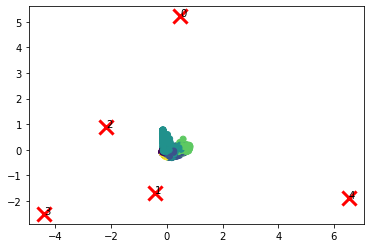

In [238]:
numClusters = elbow(x_text_c_array, max_clust = 10)
print("Number of clusters: %d" %numClusters)

kmean_model = KMeans( n_clusters = numClusters )
kmean_model.fit( x_text_c_array )
cluster_graph(X_text, kmean_model)

In [239]:
tfidf = TfidfVectorizer(max_df=0.7, min_df = 50, stop_words=stop_word)
X_text = tfidf.fit_transform(cleaned_text_list)
print("# Features:", str(len(tfidf.get_feature_names())))

tfidf_array = X_text.toarray()
print(tfidf_array.shape)

# Features: 1712
(10788, 1712)


In [ ]:
# tfidf.get_feature_names()

In [241]:
numClusters = elbow(tfidf_array, max_clust = 10)
print("Number of clusters: %d" %numClusters)

kmean_model = KMeans( n_clusters = numClusters )
kmean_model.fit( tfidf_array )

Number of clusters: 4


KMeans(n_clusters=4)

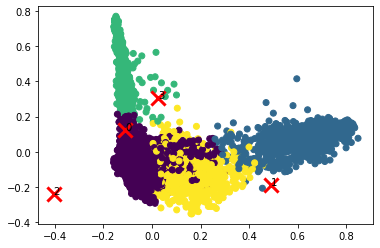

In [242]:
cluster_graph(X_text, kmean_model)

In [243]:
lda_model = LDA(learning_method = 'online', n_components=numClusters, random_state=1).fit(x_text_c_array)
c_fn = c.get_feature_names()
no_top_words = 15

display_topics(lda_model, c_fn, no_top_words)
print()

Topic 0: dlrs loss year billion profit revs sales quarter january note february share oper rose shrs
Topic 1: bank market rate banks billion rates money would interest today week central dollar foreign analysts
Topic 2: company dlrs shares stock corp share offer group april common would dividend record stake unit
Topic 3: trade would tonnes year last prices japan exports production market export told government economic wheat



In [244]:
transformed_x = lda_model.transform(x_text_c_array)
transformed_x

array([[6.58704961e-02, 8.49398086e-04, 3.04988970e-02, 9.02781209e-01],
       [7.74616911e-03, 7.80536767e-03, 7.54562270e-03, 9.76902841e-01],
       [2.19069691e-01, 3.51891528e-03, 3.52401948e-03, 7.73887374e-01],
       ...,
       [2.89254070e-02, 2.81436535e-02, 9.14787409e-01, 2.81435309e-02],
       [9.49673066e-01, 1.66984202e-02, 1.68856505e-02, 1.67428634e-02],
       [8.47702407e-01, 5.00190680e-02, 5.21118980e-02, 5.01666273e-02]])

# Selecting certain parts of speech

In [250]:
# nltk.pos_tag(nltk.word_tokenize(reuters.raw(fileids = reuters.fileids()[2])))

# chosen_tags = [token for token, pos in nltk.pos_tag(nltk.word_tokenize(reuters.raw(fileids = reuters.fileids()[2]))) if pos in ('JJ', 'JJR', 'JJS','NNP', 'NN', 'NNS', 'RB', 'RBS', 'VB', 'VBD', 'VBN', 'VBP', 'VBZ')]
# print(chosen_tags)

cleaned_text_list_pos = []
# print(reuters.categories())

for doc in reuters.fileids():
    # print(doc + " | category: %s" %(reuters.categories(fileids = doc)))
    #print(reuters.words(fileids = doc))
    
    cleaned_text = clean_text(reuters.raw(fileids = doc), pos_pick = True)
    # print(cleaned_text)
    cleaned_text_list_pos.append(cleaned_text)
    # break  




In [ ]:
cleaned_text_list_pos[:5]

In [254]:
c = CountVectorizer(stop_words=stop_word, max_df = 0.7, min_df = 50)
X_text_cpos = c.fit_transform(cleaned_text_list_pos)
#print(X_text_c)
x_text_cpos_array = X_text_cpos.toarray()
x_text_cpos_array.shape

(10788, 1605)

Number of clusters: 6


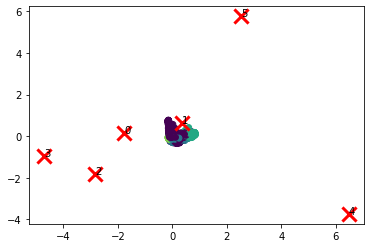

In [255]:
numClusters = elbow(x_text_cpos_array, max_clust = 10)
print("Number of clusters: %d" %numClusters)

kmean_model = KMeans( n_clusters = numClusters )
kmean_model.fit( x_text_cpos_array )
cluster_graph(X_text, kmean_model)

In [256]:
tfidf = TfidfVectorizer(max_df=0.7, min_df = 50, stop_words=stop_word)
X_text_pos = tfidf.fit_transform(cleaned_text_list)
print("# Features:", str(len(tfidf.get_feature_names())))

tfidf_pos_array = X_text_pos.toarray()
print(tfidf_pos_array.shape)

# Features: 1712
(10788, 1712)


In [257]:
numClusters = elbow(tfidf_pos_array, max_clust = 10)
print("Number of clusters: %d" %numClusters)

kmean_model = KMeans( n_clusters = numClusters )
kmean_model.fit( tfidf_pos_array )

Number of clusters: 4


KMeans(n_clusters=4)

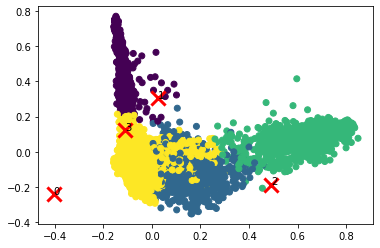

In [258]:
cluster_graph(X_text, kmean_model)

In [269]:
lda_model = LDA(learning_method = 'online', n_components=4, random_state=1).fit(x_text_cpos_array)
c_fn = c.get_feature_names()

In [270]:
len(c_fn)

1605

In [271]:
lda_model.components_.shape

(4, 1605)

In [274]:
no_top_words = 25
display_topics(lda_model, c_fn, no_top_words)
print()

Topic 0: dlrs loss company year corp share profit shares revs stock group sales note april offer oper quarter dividend common shrs march earnings record sale unit
Topic 1: trade also market told price last japan agreement industry prices international government officials world today meeting japanese spokesman united talks president countries foreign companies made
Topic 2: bank rate dollar market rates banks growth money year exchange interest foreign dlrs currency central economic last reserves government rise week japan marks dealers economy
Topic 3: year tonnes dlrs january february last production prices exports export wheat rose imports sugar trade department rise december march output month grain agriculture corn total



In [273]:
transformed_x = lda_model.transform(x_text_cpos_array)
transformed_x

array([[0.03187881, 0.6501642 , 0.08111129, 0.23684569],
       [0.00763478, 0.00845218, 0.00784835, 0.97606469],
       [0.00365353, 0.39958124, 0.00377604, 0.59298919],
       ...,
       [0.91497802, 0.0279999 , 0.02892312, 0.02809895],
       [0.94977775, 0.0167135 , 0.01670865, 0.0168001 ],
       [0.84826921, 0.0500382 , 0.0503397 , 0.05135289]])

## Gensim

In [ ]:
cleaned_text_list_gs = []

print(reuters.categories())

for doc in reuters.fileids():
    # print(doc + " | category: %s" %(reuters.categories(fileids = doc)))
    #print(reuters.words(fileids = doc))
    cleaned_text = clean_text(reuters.raw(fileids = doc)).split()
    cleaned_text_list_gs.append(cleaned_text)

In [ ]:
dictionary = gensim.corpora.Dictionary(cleaned_text_list_gs)
# count = 0
# for k, v in dictionary.iteritems():
#     print(k, v)
#     count += 1
#     if count > 10:
#         break

In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in cleaned_text_list_gs]
# bow_corpus

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
# For each topic, we will explore the words occuring in that topic and its relative weight.

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))